### Random Forest Classifiers and NBA Positions
In this exercise, we will explore the use of random forest classifiers to determine the positions of NBA player based on their in-game statistics. This will use 5 years worth of data (2016-2020) sourced from https://www.basketball-reference.com/

This project references the [work done by Phillip Wilkinson](https://github.com/PhilipDW183/NBA_positions/blob/main/NBA_positions.ipynb) and is solely for the sake of my review and practice.

In [64]:
import pandas as pd
NBA_2016 = pd.read_csv("C:/Users/Raymond Luu/Downloads/Coding/Datasets/NBA_2016.csv")
NBA_2017 = pd.read_csv("C:/Users/Raymond Luu/Downloads/Coding/Datasets/NBA_2017.csv")
NBA_2018 = pd.read_csv("C:/Users/Raymond Luu/Downloads/Coding/Datasets/NBA_2018.csv")
NBA_2019 = pd.read_csv("C:/Users/Raymond Luu/Downloads/Coding/Datasets/NBA_2019.csv")
NBA_2020 = pd.read_csv("C:/Users/Raymond Luu/Downloads/Coding/Datasets/NBA_2020.csv")

NBA_2016["Year"] = '2016'
NBA_2017["Year"] = '2017'
NBA_2018["Year"] = '2018'
NBA_2019["Year"] = '2019'
NBA_2020["Year"] = '2020'

NBA = pd.concat([NBA_2016,NBA_2017,NBA_2018,NBA_2019,NBA_2020])

### Data Cleaning

We have a couple of steps to take for preliminary cleaning. 

1) We also want to eliminate duplicate players which can occur in the data due to mid-season trades. For traded players, the Tm (Team) value of 'Tot' totals up the player's contributions on all teams throughout the season.

2) For the sake of simplicity, I will also filter out the hybrid positions that some players have.

3) Due to inequal minute distributions, I will convert some of the raw averages to a per 36m rate. 

4) Finally, we drop some of the columns used that either have no bearing on in-game performance or are redundant.

In [65]:
#Identifying traded players and filtering
NBA["Player"] = NBA["Player"]+NBA["Year"]

Player_freq = NBA.Player.value_counts()
Traded = NBA[(NBA.Player.isin(Player_freq.index[Player_freq > 1])) & (NBA.Tm == 'TOT')]
Non_Traded = NBA[(NBA.Player.isin(Player_freq.index[Player_freq == 1]))]
NBA = pd.concat([Non_Traded,Traded])

#Filtering out hybrid positions
NBA = NBA[NBA.Pos.isin(["PG","SG","SF","PF","C"])]

#Creating Per 36m statistics
Average_stats = ["FGA","3PA","2PA","FTA","ORB","DRB","TRB","AST","STL","BLK","TOV","PF","PTS"]
for x in [x for x in NBA.columns.values if x in Average_stats]:
    NBA[x] = NBA[x]/NBA["MP"]*36
    
#Filling empty percentages with 0
NBA.fillna(0, inplace = True)
    
#Dropping columns
NBA.drop(columns =["Rk", "Age", "G", "GS", "3P","FG","2P","FT","eFG%","Tm", "MP","Player","FG%","TRB"], inplace = True)

In [66]:
NBA

,Pos,FGA,3PA,3P%,2PA,2P%,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,Year
0,PF,8.756757,1.945946,0.388,6.810811,0.606,2.918919,0.735,2.675676,5.108108,1.216216,1.216216,0.972973,1.216216,4.135135,12.648649,2016
1,SG,14.400000,2.400000,0.000,12.000000,0.400,12.000000,0.600,0.000000,4.800000,7.200000,7.200000,0.000000,4.800000,4.800000,16.800000,2016
2,C,7.571429,0.000000,0.000,7.571429,0.613,3.571429,0.582,3.857143,5.571429,1.142857,0.714286,1.571429,1.571429,4.000000,11.428571,2016
3,SG,12.179641,3.664671,0.382,8.514970,0.469,1.940120,0.840,0.323353,3.664671,2.155689,0.431138,0.107784,1.293413,2.155689,13.796407,2016
4,C,13.068493,0.000000,0.000,13.068493,0.478,2.712329,0.839,3.205479,8.136986,1.232877,0.739726,1.479452,2.219178,5.671233,14.794521,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,SG,17.217391,8.173913,0.319,9.043478,0.500,2.956522,0.824,0.347826,3.826087,3.478261,0.695652,1.043478,2.782609,3.652174,19.304348,2020
611,PG,5.684211,3.410526,0.417,2.273684,0.533,1.136842,0.778,0.378947,1.894737,3.789474,1.136842,0.000000,0.757895,3.031579,7.578947,2020
619,SF,10.758621,4.965517,0.333,5.793103,0.429,3.724138,0.778,0.827586,6.206897,3.310345,1.655172,0.413793,1.241379,2.068966,12.827586,2020
627,SF,18.941860,6.488372,0.332,12.453488,0.506,5.232558,0.709,1.255814,4.081395,3.872093,0.837209,1.046512,2.511628,2.511628,22.813953,2020


### Running Random Forest and Evaluating
Now that we have our data cleaned to our liking, we can import the random forest classifier and prepare our data for training. We will run once then evaluate.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Split the features and the positions and then split into Test/Training
X = NBA.drop(columns = ["Pos"])
Y = NBA.Pos

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=23)

clf = RandomForestClassifier(n_estimators =100, oob_score=True, max_depth =3,
                            random_state = 23)

clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=23, verbose=0,
                       warm_start=False)

We now will visualize the results of the Random Forest Classifier with a confusion matrix and then check for Accuracy, Precision, and Recall. 

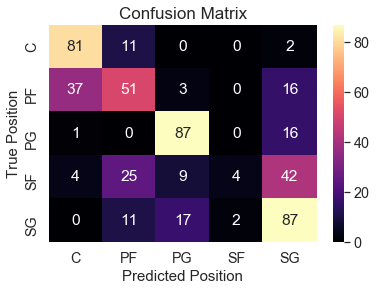

<Figure size 864x864 with 0 Axes>

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = clf.predict(X_test)

# get the confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)

matrix_df = pd.DataFrame(confusion_matrix)

# set axis to add title and axis labels later
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(12,12))

plot = sns.heatmap(matrix_df, annot=True, fmt='g', ax=ax, cmap = "magma")

#axis labels and title
ax.set_title('Confusion Matrix', fontsize = 17)
ax.set_xlabel('Predicted Position', fontsize = 15)
ax.set_ylabel('True Position', fontsize = 15)

labels = ("C", "PF", "PG", "SF", "SG")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()


fig = plot.get_figure()

In [70]:
print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           C       0.66      0.86      0.75        94
          PF       0.52      0.48      0.50       107
          PG       0.75      0.84      0.79       104
          SF       0.67      0.05      0.09        84
          SG       0.53      0.74      0.62       117

    accuracy                           0.61       506
   macro avg       0.63      0.59      0.55       506
weighted avg       0.62      0.61      0.56       506



In [71]:
train_accuracy = clf.score(X_train, Y_train)
test_accuracy = clf.score(X_test, Y_test)

print(f"The training score of the random forest classifier is : {train_accuracy:.3f}")
print(f"The test score of the random forest classifier is {test_accuracy:.3f}")

The training score of the random forest classifier is : 0.601
The test score of the random forest classifier is 0.613


In [72]:
#Seeing the distribution of Predictions
import numpy as np 

unique, counts = np.unique(Y_pred, return_counts=True)
dict(zip(unique, counts))

{'C': 123, 'PF': 98, 'PG': 116, 'SF': 6, 'SG': 163}

We now see that classifier is having the easiest time correctly identifying PG and C. 
SF seems like a particularly difficult position to guess from these features. Particularly, it hardly ever classifies a player as a SF. It also seems to overly aggressively predict SG.

We can look at the decision making of a singular tree to get some intuition on how decisions are being made.

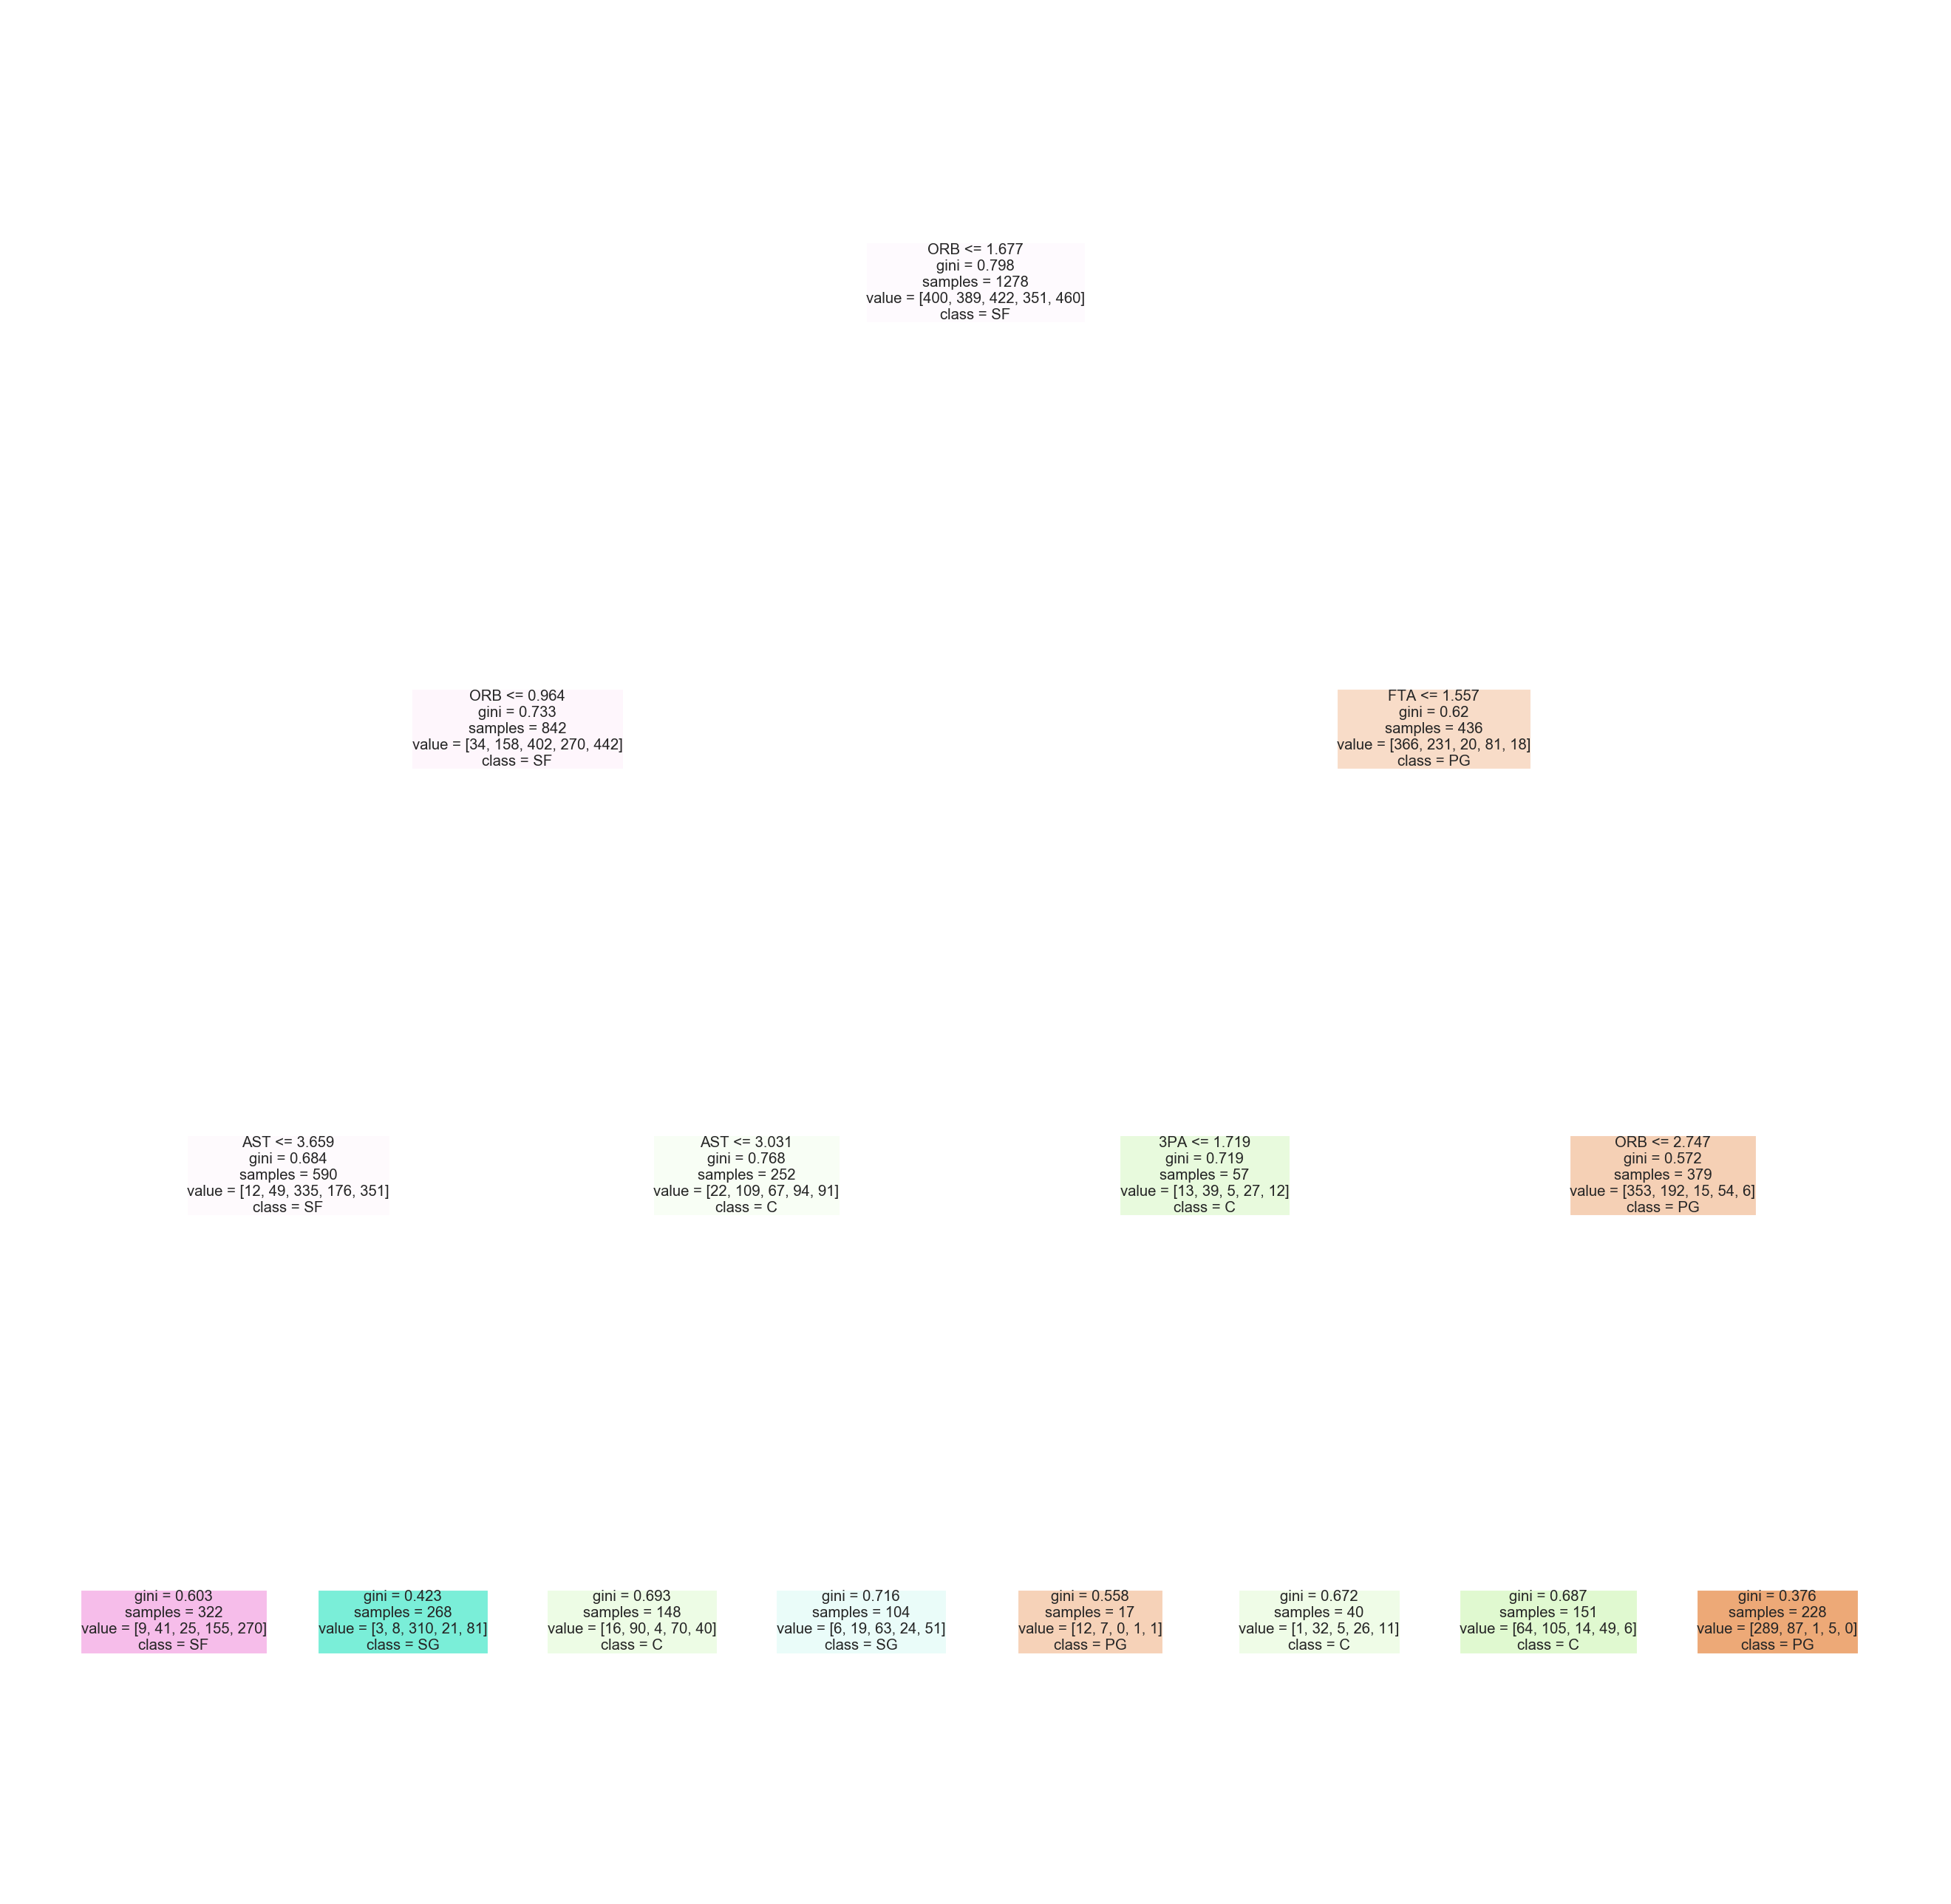

In [73]:
from sklearn import tree
import numpy as np

a = np.array(Y_test.unique())
a = a.astype('<U10')
a

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf.estimators_[1],
                   feature_names = X.columns, 
                   class_names = a,
                   filled = True);

### Improving our model by tuning hyperparameters

From this individual decision tree, we can see that hardly any of the players actually get sorted into the PF class altogether! 

Not all trees will omit a class altogether of course but this makes me suspect that tuning hyperparameters to allow for greater individual tree depth will allow for finer classification. We will be using GridSearchCV to optimize our max_depth for further complexity and min_samples_split for the criteria of Accuracy.

In [76]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'max_depth': [4,5,6,7,8], 
                     'min_samples_split': [2,3,5,7,9]}]

scores = ['accuracy']

for score in scores:
    
    print()
    print(f"Tuning hyperparameters for {score}")
    print()
    
    clf = GridSearchCV(
        RandomForestClassifier(), tuned_parameters,
        scoring = f'{score}'
    )
    clf.fit(X_train, Y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")


Tuning hyperparameters for accuracy

Best parameters set found on development set:

{'max_depth': 8, 'min_samples_split': 2}

Grid scores on development set:
0.593 (+/-0.042) for {'max_depth': 4, 'min_samples_split': 2}
0.597 (+/-0.025) for {'max_depth': 4, 'min_samples_split': 3}
0.592 (+/-0.027) for {'max_depth': 4, 'min_samples_split': 5}
0.596 (+/-0.037) for {'max_depth': 4, 'min_samples_split': 7}
0.601 (+/-0.034) for {'max_depth': 4, 'min_samples_split': 9}
0.608 (+/-0.040) for {'max_depth': 5, 'min_samples_split': 2}
0.610 (+/-0.030) for {'max_depth': 5, 'min_samples_split': 3}
0.613 (+/-0.031) for {'max_depth': 5, 'min_samples_split': 5}
0.614 (+/-0.039) for {'max_depth': 5, 'min_samples_split': 7}
0.614 (+/-0.034) for {'max_depth': 5, 'min_samples_split': 9}
0.619 (+/-0.053) for {'max_depth': 6, 'min_samples_split': 2}
0.618 (+/-0.043) for {'max_depth': 6, 'min_samples_split': 3}
0.625 (+/-0.032) for {'max_depth': 6, 'min_samples_split': 5}
0.615 (+/-0.054) for {'max_depth': 

We find that the best Hyperparameters are 'max_depth': 8, 'min_samples_split': 2, and now we can run Random Forest again to see if the extra depth alleviates the issues that we've encountered in our previous run of the classifier. 

In [77]:
clf_tuned = RandomForestClassifier(n_estimators =200, oob_score=True, 
                             max_depth =clf.best_params_["max_depth"], 
                             min_samples_split = clf.best_params_['min_samples_split'],
                            random_state = 23)

clf_tuned.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=23, verbose=0,
                       warm_start=False)

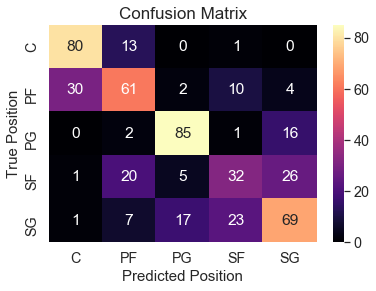

<Figure size 864x864 with 0 Axes>

In [78]:
Y_pred_tuned = clf_tuned.predict(X_test)

# get the confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_tuned)

matrix_df = pd.DataFrame(confusion_matrix)

# set axis to add title and axis labels later
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(12,12))

plot = sns.heatmap(matrix_df, annot=True, fmt='g', ax=ax, cmap = "magma")

#axis labels and title
ax.set_title('Confusion Matrix', fontsize = 17)
ax.set_xlabel('Predicted Position', fontsize = 15)
ax.set_ylabel('True Position', fontsize = 15)

labels = ("C", "PF", "PG", "SF", "SG")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()


fig = plot.get_figure()

In [79]:
print(metrics.classification_report(Y_test, Y_pred_tuned))

              precision    recall  f1-score   support

           C       0.71      0.85      0.78        94
          PF       0.59      0.57      0.58       107
          PG       0.78      0.82      0.80       104
          SF       0.48      0.38      0.42        84
          SG       0.60      0.59      0.59       117

    accuracy                           0.65       506
   macro avg       0.63      0.64      0.63       506
weighted avg       0.64      0.65      0.64       506



In [80]:
train_accuracy = clf_tuned.score(X_train, Y_train)
test_accuracy = clf_tuned.score(X_test, Y_test)

print(f"The training score of the random forest classifier is : {train_accuracy:.3f}")
print(f"The test score of the random forest classifier is {test_accuracy:.3f}")

The training score of the random forest classifier is : 0.884
The test score of the random forest classifier is 0.646


In [81]:
#Seeing the distribution of Predictions
unique, counts = np.unique(Y_pred_tuned, return_counts=True)
dict(zip(unique, counts))

{'C': 112, 'PF': 103, 'PG': 109, 'SF': 67, 'SG': 115}

### Conclusion
Upon rerunning with tuned hyperparameters, we improved our classifier test score from 0.613 to 0.646. Additionally we can see that the added depth allowed the algorithm to classify more players into the SF position and alleviated the initial drastic overestimation of the SG position.

Predictably, the positions at the ends of the size spectrum (PG and C) are the most defined as they typically have more specialized roles that reflect in the box score. SFs truly is a flexible position whose box score production seems to be uniformly distributed in similairity with their neighorboring SG and PF positions. PF production seems more similar to their bigger neighbor C than a SF based on the misclassifications.

Overall the Random Forest classifier seems to be able to classify positions at around a 65% accuracy and is most accurate for PGs and Cs. 